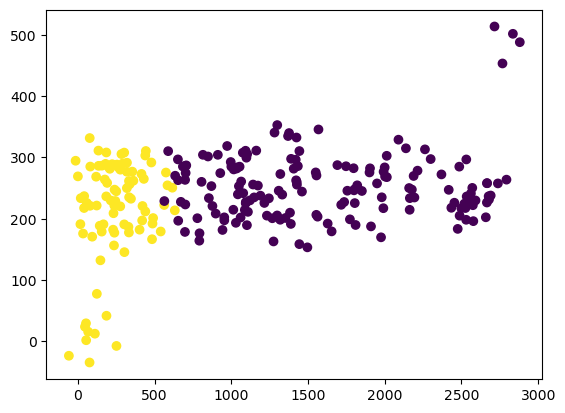

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Load and display the first 3 rows of the dataset
df =pd.read_csv("drawndata.csv")
df.head(3)
# Extract features (X) and labels (y)
X = df[['x','y']].values
y=df['z'] =="a"
# Scatter plot of the original data
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

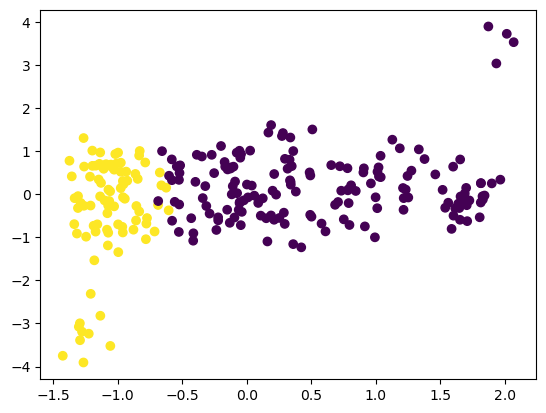

In [2]:
# Standardize the features using StandardScaler
from sklearn.preprocessing import StandardScaler, QuantileTransformer
X_new = StandardScaler().fit_transform(X)
# Scatter plot of the standardized data
plt.scatter(X_new[:,0], X_new[:,1], c=y);

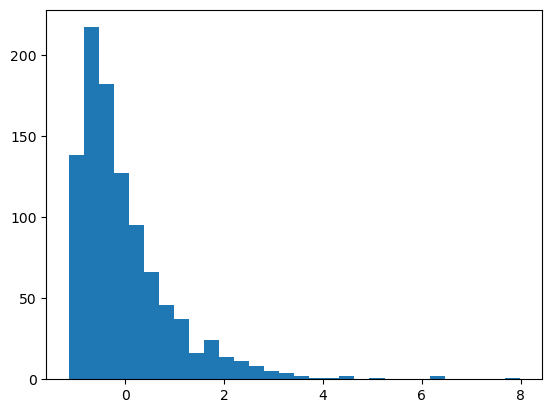

In [3]:
# Generate a random dataset with an exponential distribution and a normal distribution
x = np.random.exponential(10,(1000)) + np.random.normal(0,1,(1000))
# Histogram of the generated dataset
plt.hist((x-np.mean(x))/np.std(x),30); #or only x

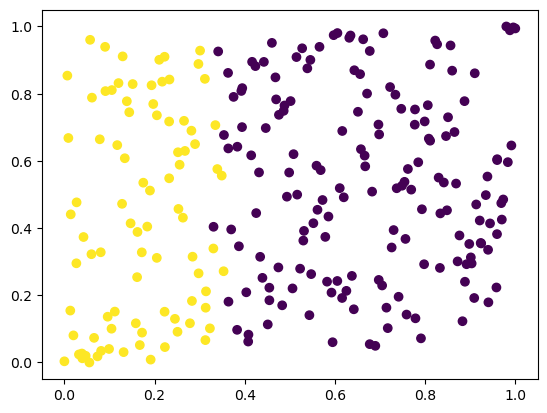

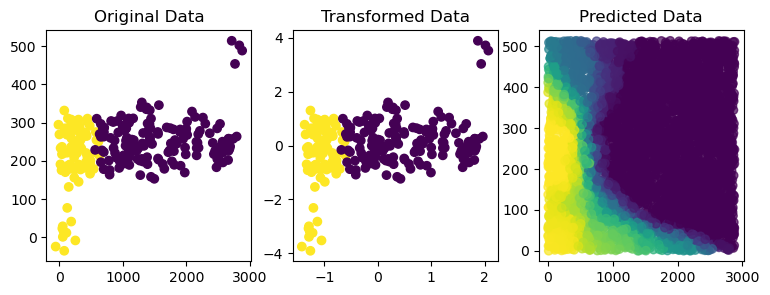

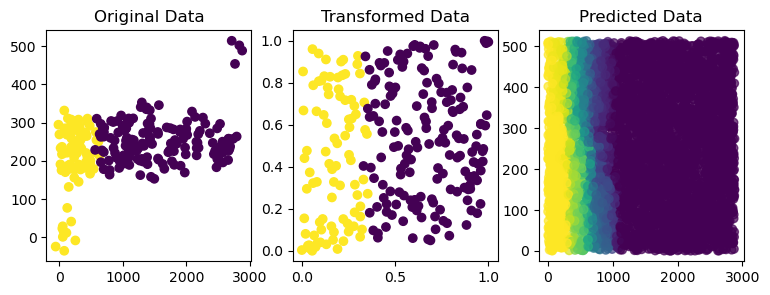

In [4]:
# Transform features using QuantileTransformer
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 

X_new = QuantileTransformer(n_quantiles=100).fit_transform(X)
# Scatter plot of the transformed data
plt.scatter(X_new[:, 0], X_new[:, 1], c=y);

# Function to plot the output of a pipeline
def plot_output(scaler):
    pipe = Pipeline([
        ("scale", scaler),
        ("model", KNeighborsClassifier(n_neighbors=20, weights='distance'))
    ])

    pred = pipe.fit(X, y).predict(X)

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Original Data")
    plt.subplot(132)
    X_tfm = scaler.transform(X)
    plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=y)
    plt.title("Transformed Data")
    plt.subplot(133)
    X_new = np.concatenate([
        np.random.uniform(0, X[:, 0].max(), (5000, 1)), 
        np.random.uniform(0, X[:, 1].max(), (5000, 1))
    ], axis=1)
    y_proba = pipe.predict_proba(X_new)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_proba[:, 1], alpha=0.7)
    plt.title("Predicted Data")
# Plot the output using StandardScaler
plot_output(scaler=StandardScaler())
# Plot the output using QuantileTransformer
plot_output(scaler=QuantileTransformer(n_quantiles=100))

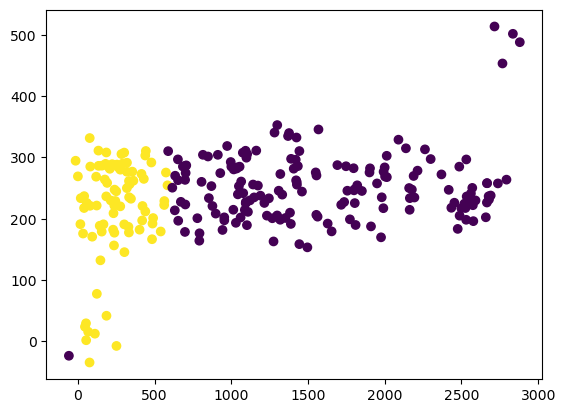

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scale", PolynomialFeatures()),
    ("model", LogisticRegression())
])

pred = pipe.fit(X,y).predict(X)
plt.scatter(X[:,0], X[:,1], c=pred)

arr = np.array(["low", "low", "high", "medium"]).reshape(-1,1)


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False, handle_unknown = "ignore")
enc.fit_transform(arr)
enc.transform([["zero"]])

array([[0., 0., 0.]])

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Load a credit card dataset and display the first 3 rows
df=pd.read_csv("creditcard.csv")[:80000]
df.head(3)

# Extract features (X) and labels (y)
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} Y={y.shape}, #Fraud Case={y.sum()}"

'Shapes of X=(80000, 28) Y=(80000,), #Fraud Case=196'

In [8]:
# Fit a Logistic Regression model with class weights and check the sum of predicted fraud cases
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression(class_weight={0:1,1:2}, max_iter=1000)
mod.fit(X,y).predict(X).sum()
                    

171

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

make_scorer(min_recall_precision, greater_is_better=False)
#Fraud is like an outlier
#expect 0/1 not -1
# GridSearchCV for Logistic Regression with class weights
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
grid.fit(X, y);
#sample_weight=np.log(1+df['Amount'])
#precision_score: Given that I predict fraud how accurate am I
#recall_score: Did I get all the fraud cases
#f(y_true,y_pred) ->make_scorer-> s(est,X,y,w)

In [ ]:
# Plot the results of the grid search
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)

for score in ['mean_train_recall_score', 'mean_train_precision']:
    plt.scatter([_[1] for _ in df_results['param_class_weight']], 
             y=df_results[score.replace('train','test')], 
             label=score)
plt.legend();


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer
#precision_score: Given that I predict fraud how accurate am I
#recall_score: Did I get all the fraud cases

# GridSearchCV for Logistic Regression with class weights and different scoring metrics
grid = GridSearchCV(
       estimator = LogisticRegression(max_iter=1000),
       param_grid = {'class_weight':[{0:1,1:v} for v in np.linspace(1,20,30)]},
       scoring = {'precision': make_scorer(precision_score), 
                  'recall_score': make_scorer(recall_score)},
       refit = 'precision',
       return_train_score=True,
       cv = 10,
       n_jobs = -1
)
grid.fit(X,y);

In [ ]:
# Plot the results of the grid search
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend();

In [9]:
# Apply Isolation Forest for outlier detection
# Count the number of predicted outliers
from collections import Counter
from sklearn.ensemble import IsolationForest
mod=IsolationForest().fit(X)
Counter(mod.predict(X))
np.where(mod.predict(X)==-1,1,0)


array([0, 0, 0, ..., 0, 0, 0])

In [15]:
from sklearn.model_selection import GridSearchCV

def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    precision = precision_score(y, np.where(preds == -1, 1, 0), zero_division=1)
    
    if np.isnan(precision):
        # Gestisci il caso in cui la precisione non può essere calcolata
        return 0.0  # O qualsiasi altro valore predefinito che ha senso nel tuo contesto
    
    return precision

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    recall = recall_score(y, np.where(preds == -1, 1, 0), zero_division=1)
    if np.isnan(recall) or recall is None:
        # Gestisci il caso in cui il valore di recall non può essere calcolato
        return 0.0  # O qualsiasi altro valore predefinito che ha senso nel tuo contesto
    return recall

In [ ]:
# GridSearchCV for Isolation Forest with custom outlier precision and recall metrics
grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y);

In [ ]:
# Plot the results of the grid search
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend();


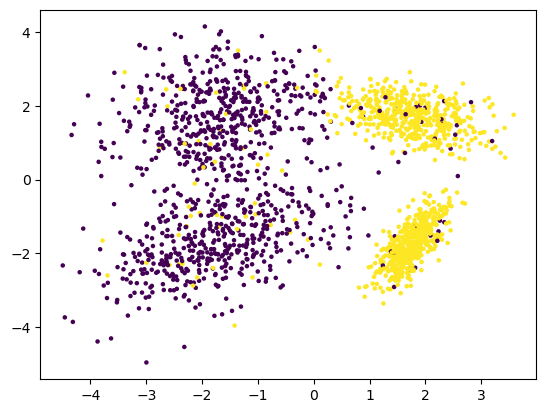

In [18]:
# Voting Classifier example with Logistic Regression and KNeighborsClassifier
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

# Generate a synthetic dataset
X,y = make_classification(n_samples=2000, n_features=2, n_redundant=0, random_state=21, class_sep=1.75, flip_y=0.1)
plt.scatter(X[:,0], X[:,1], c=y, s=5)
#VotingClassifier([est2,est2,...], weight=[1,2,...])

In [19]:
# Create individual classifiers
clf1=LogisticRegression().fit(X,y)
clf2=KNeighborsClassifier(n_neighbors=10).fit(X,y)

# Create a VotingClassifier with soft voting
clf3=VotingClassifier(estimators=[('clf1', clf1), ('clf2',clf2)], voting='soft', weights=[0.5,0.5])
# Fit the ensemble model
clf3.fit(X,y)

VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', KNeighborsClassifier(n_neighbors=10))],
                 voting='soft', weights=[0.5, 0.5])

In [20]:
# Function to visualize the output of different classifiers
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

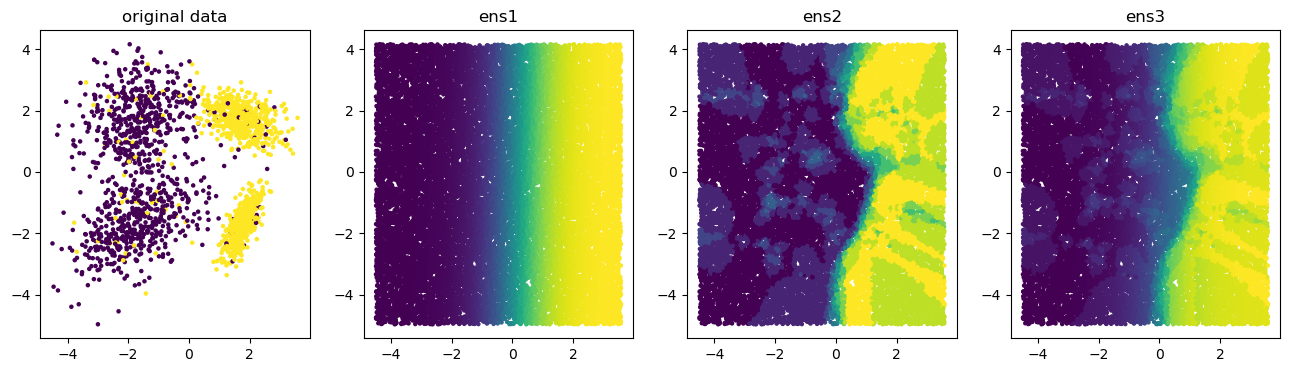

In [21]:
# Plot the output of different classifiers
make_plots()

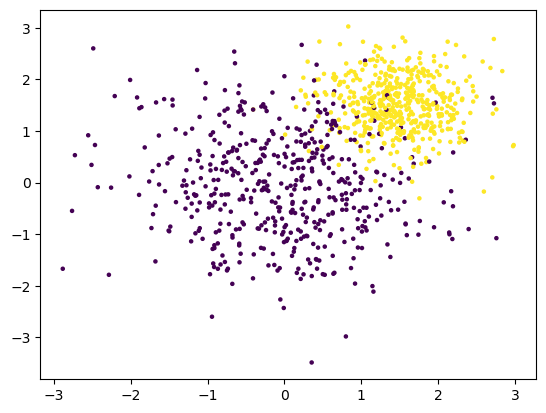

In [22]:
# Generate blobs for a classification problem
from sklearn.datasets import make_blobs
# Use GridSearchCV for Logistic Regression with class weights and Thresholder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
from sklego.meta import Thresholder
# Create a dataset with 2 clusters
X,y = make_blobs(1000, centers=[(0,0),(1.5,1.5)], cluster_std=[1,0.5])
plt.scatter(X[:,0], X[:,1], c=y, s=5);

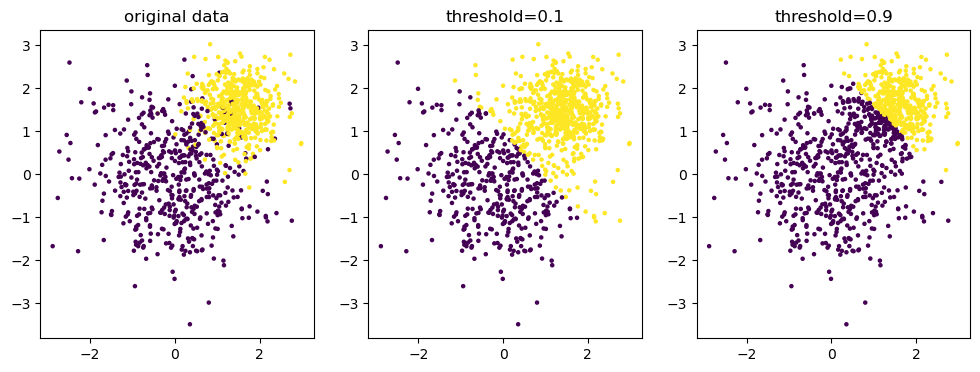

In [23]:
# Fit a logistic regression model with Thresholder
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X,y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X,y)
# Visualize the output with different thresholds
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [24]:
# Create a pipeline with Thresholder and use GridSearchCV for finding the best threshold
pipe = Pipeline([("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))])
mod = GridSearchCV(estimator=pipe,
                  param_grid={"model__threshold": np.linspace(0.1,0.9,50)},
                  scoring={"precision": make_scorer(precision_score),
                           "recall": make_scorer(recall_score),
                           "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X,y);

In [25]:
# Import libraries for Linear Regression and feature preprocessing
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

# Load the chicken weight dataset
df = load_chicken(as_frame=True)

# Function to plot the model predictions per group
def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

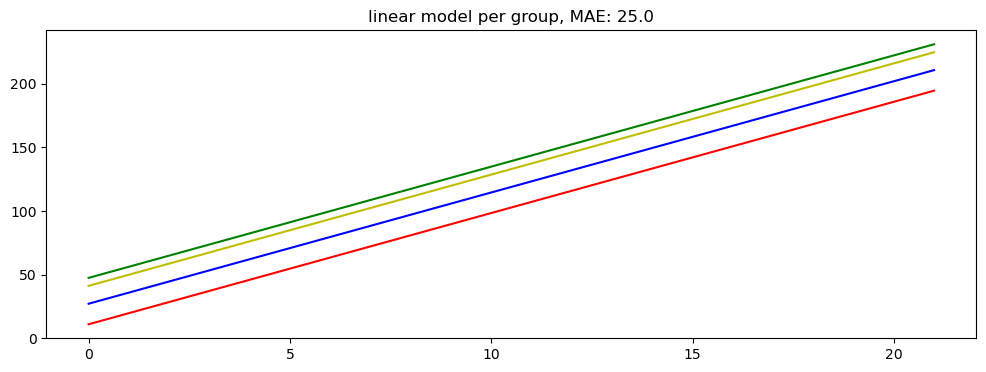

In [26]:
# Create a feature pipeline with OneHotEncoder and StandardScaler
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto", sparse_output=False))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler())
        ]))
    ]))
])

# Create a linear regression model using the feature pipeline
pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

# Plot the model predictions per group
plot_model(pipe)

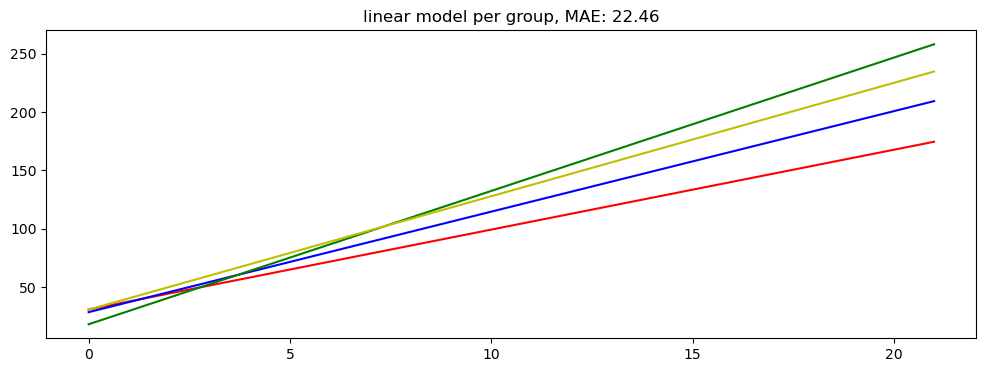

In [27]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=["diet"])
plot_model(mod)

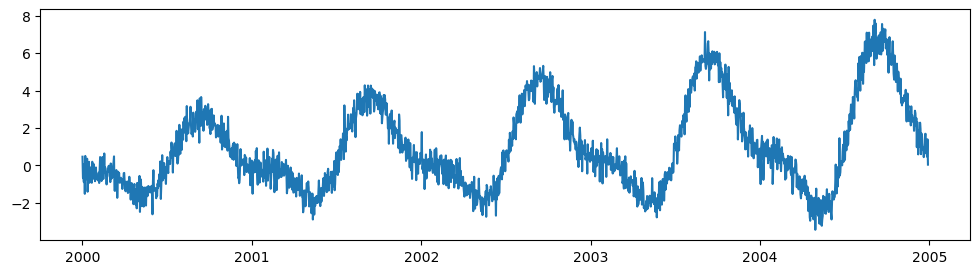

In [28]:
# Import libraries for GroupedPredictor and DecayEstimator
from sklego.meta import GroupedPredictor, DecayEstimator
from sklego.datasets import make_simpleseries

# Generate a time series dataset
yt = make_simpleseries(seed=1)
dates = pd.date_range("2000-01-01", periods=len(yt))
df = (pd.DataFrame({"yt": yt, "date": dates})
     .assign(m=lambda d:d.date.dt.month)
     .reset_index())
plt.figure(figsize=(12,3))
plt.plot(dates, make_simpleseries(seed=1));


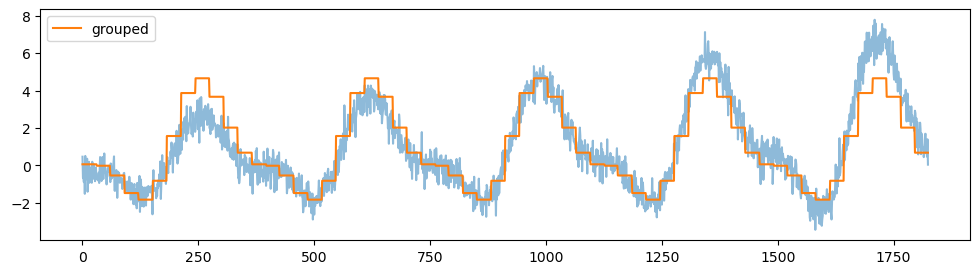

In [29]:
from sklearn.dummy import DummyRegressor
# Fit a GroupedPredictor with DummyRegressor for monthly grouped predictions
mod1 = (GroupedPredictor(DummyRegressor(), groups=["m"])
        .fit(df[['m']], df['yt']))

# Plot the original time series and the grouped predictions
plt.figure(figsize=(12,3))
plt.plot(df['yt'], alpha=0.5)
plt.plot(mod1.predict(df[['m']]), label="grouped")
plt.legend();

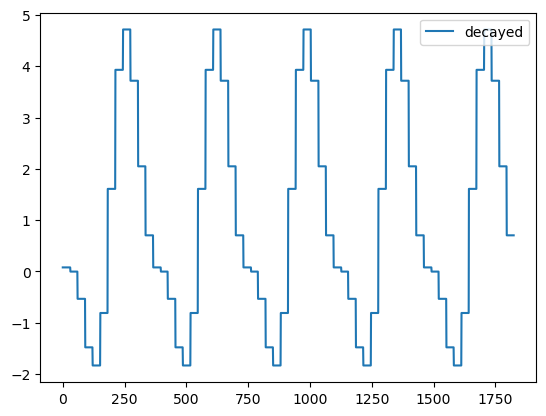

In [30]:
# Fit a GroupedPredictor with DecayEstimator for monthly decayed predictions
mod2= (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=["m"])
      .fit(df[['index','m']], df['yt']))
plt.plot(mod2.predict(df[['index','m']]), label="decayed")
plt.legend();

In [31]:
# Install the human-learn and bokeh packages
%pip install human-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install --upgrade bokeh==2.4.0

  Using cached bokeh-2.4.0-py3-none-any.whl (18.4 MB)
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.2.1
    Uninstalling bokeh-2.2.1:
      Successfully uninstalled bokeh-2.2.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 1.2.3 requires bokeh<3.3.0,>=3.1.1, but you have bokeh 2.4.0 which is incompatible.


In [33]:
# Import necessary libraries for creating interactive charts
import numpy as np
import pandas as pd
from hulearn.datasets import load_titanic
from sklearn.model_selection import GridSearchCV
# Load the Titanic dataset
df = load_titanic(as_frame=True)
X, y = df.drop(columns=["survived"]), df["survived"]

In [34]:
# Display the first few rows of the dataset
df.head()

,survived,pclass,name,sex,age,fare,sibsp,parch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,0,0


In [35]:
# Function to classify passengers based on fare threshold
def fare_based(dataf, threshold=10):
    return np.array(dataf['fare'] > threshold).astype(int)
fare_based(X)

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,

In [36]:
from hulearn.classification import FunctionClassifier
# Create a FunctionClassifier using fare_based function
mod=FunctionClassifier(fare_based, threshold=10)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer
# Use GridSearchCV for tuning the threshold
grid = GridSearchCV(mod, 
                    cv=2,
                    param_grid={"threshold": np.linspace(0,100,30)},
                    scoring={"accuracy": make_scorer(accuracy_score),
                             "precision": make_scorer(precision_score),
                             "recall": make_scorer(recall_score)},
                    refit="accuracy"
                   )
grid.fit(X,y)

GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function fare_based at 0x000000C1B6B6E660>,
                                          threshold=10),
             param_grid={'threshold': array([  0.        ,   3.44827586,   6.89655172,  10.34482759,
        13.79310345,  17.24137931,  20.68965517,  24.13793103,
        27.5862069 ,  31.03448276,  34.48275862,  37.93103448,
        41.37931034,  44.82758621,  48.27586207,  51.72413793,
        55.17241379,  58.62068966,  62.06896552,  65.51724138,
        68.96551724,  72.4137931 ,  75.86206897,  79.31034483,
        82.75862069,  86.20689655,  89.65517241,  93.10344828,
        96.55172414, 100.        ])},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

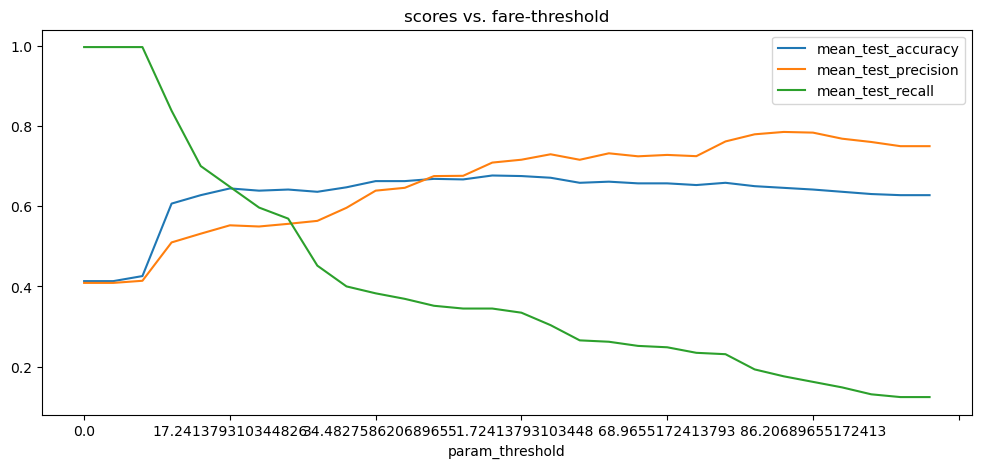

In [37]:
# Create a DataFrame for the scores vs. fare-threshold
score_df = (pd.DataFrame(grid.cv_results_)
           .set_index('param_threshold')
           [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']])
# Plot the scores vs. fare-threshold
score_df.plot(figsize=(12,5), title="scores vs. fare-threshold");

In [ ]:
#Pseudo code
import numpy as np
from hulearn.outlier import InteractiveOutlierDetector
from hulearn.classification import FunctionClassifier, InteractiveClassifier

outlier    = WhatEverOutlier().fit(X, y)
classifier = WhatEverClassifier().fit(X, y)

def make_decision(dataf, threshold=0.8):
    # First we create a resulting array with all the predictions
    res = classifier.predict(dataf)

    # If we detect doubt, "classify" it as a fallback instead.
    proba = classifier.predict_proba(dataf)
    res = np.where(proba.max(axis=1) < threshold, "doubt_fallback", res)

    # If we detect an outlier, we'll fallback too.
    res = np.where(outlier.predict(dataf) == -1, "outlier_fallback", res)

    # This `res` array contains the output of the drawn diagram.
    return res

fallback_model = FunctionClassifier(make_decision, threshold=0.8)

In [53]:
%pip install scikit-lego

Note: you may need to restart the kernel to use updated packages.


In [38]:
# Import load_penguins dataset from scikit-lego
from sklego.datasets import load_penguins
from hulearn.experimental.interactive import InteractiveCharts
# Load the penguins dataset
df= load_penguins(as_frame=True).dropna()
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male


In [39]:
# Create an instance of InteractiveCharts for interactive visualization
clf = InteractiveCharts(df, labels="species")
# Add a scatter plot for bill length and bill depth
clf.add_chart(x="bill_length_mm", y="bill_depth_mm")
#or x="flipper_length_mm" and y="body_mass_g"

Loading BokehJS ...

In [40]:
# Display the data and interactive charts
clf.data()

[{'chart_id': '37f2e4a4-4',
  'x': 'bill_length_mm',
  'y': 'bill_depth_mm',
  'polygons': {'Adelie': {'bill_length_mm': [], 'bill_depth_mm': []},
   'Gentoo': {'bill_length_mm': [], 'bill_depth_mm': []},
   'Chinstrap': {'bill_length_mm': [], 'bill_depth_mm': []}}}]

In [41]:
from hulearn.classification import InteractiveClassifier
# Create an InteractiveClassifier using the data from the interactive charts
model = InteractiveClassifier(json_desc=clf.data())
X,y = df.drop(columns=['species']), df['species']
# Generate predictions using the model
preds = model.fit(X,y).predict_proba(X)


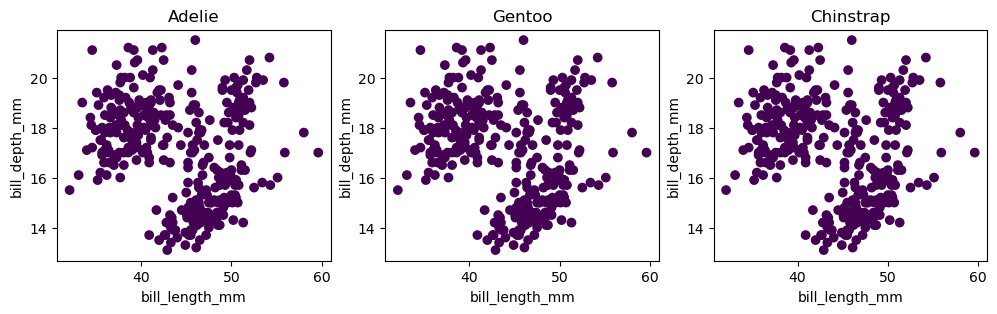

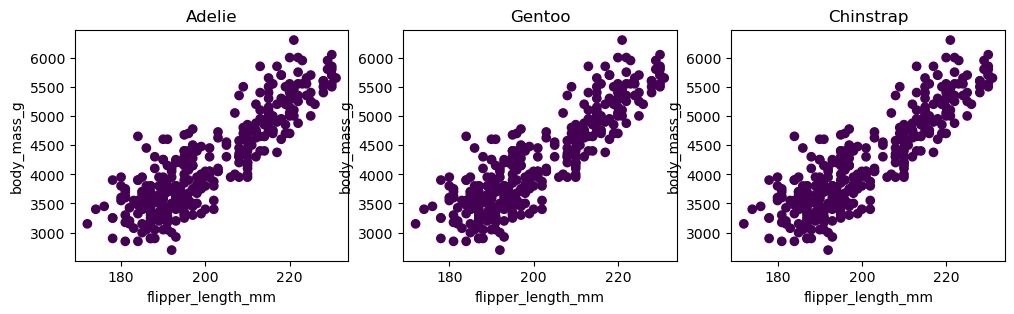

In [42]:
# Visualize the scatter plots with predicted probabilities
import matplotlib.pylab as plt
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(131+i)
    plt.scatter(X["bill_length_mm"], X["bill_depth_mm"], c=preds[:,i])
    plt.xlabel("bill_length_mm")
    plt.ylabel("bill_depth_mm")
    plt.title(model.classes_[i])
    
import matplotlib.pylab as plt
# Visualize the scatter plots with predicted probabilities for different features
plt.figure(figsize=(12,3))
for i in range(3):
    plt.subplot(131+i)
    plt.scatter(X["flipper_length_mm"], X["body_mass_g"], c=preds[:,i])
    plt.xlabel("flipper_length_mm")
    plt.ylabel("body_mass_g")
    plt.title(model.classes_[i])

In [43]:
# Drop unnecessary columns and fit the model to predict species
X,y = df.drop(columns=["species", "island", "sex"]), df["species"]
preds = model.fit(X,y).predict_proba(X)

# Create a new example for prediction
new_example=pd.DataFrame([{
    'island':'Torgersen',
    'bill_length_mm': 39.1,
    'bill_depth_mm': 18.7,
    'flipper_length_mm': 220.0,
    'body_mass_g': 5750.0,
    'sex': 'male'
}])

# Display the new example
new_example

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,220.0,5750.0,male


In [44]:
# Predict the probabilities for the new example
model.predict_proba(new_example)

array([[0.33333333, 0.33333333, 0.33333333]])

In [45]:
# Predict the species for the new example
model.predict(new_example)

array(['Adelie'], dtype='<U6')

Text(0, 0.5, 'bill_depth_mm')

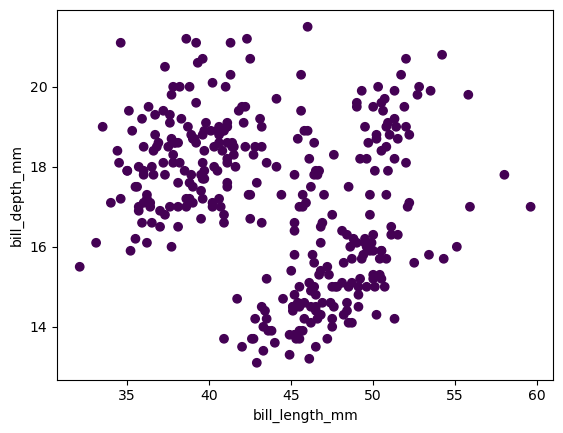

In [46]:
from hulearn.outlier import InteractiveOutlierDetector

#Load the model using drawn-data
model = InteractiveOutlierDetector(json_desc=clf.data())
X,y = df.drop(columns=['species']), df['species']
preds = model.fit(X,y).predict(X)
# Visualize the scatter plot with predicted outliers
plt.scatter(X['bill_length_mm'], X['bill_depth_mm'], c=preds)
plt.xlabel("bill_length_mm")
plt.ylabel("bill_depth_mm")

In [47]:
from hulearn.experimental.interactive import InteractiveCharts
# Create InteractiveCharts with two groups
charts = InteractiveCharts(df,labels=["group_one", "group_two"])
# Add a scatter plot for bill length and bill depth
charts.add_chart(x="bill_length_mm", y="bill_depth_mm")

Loading BokehJS ...

In [48]:
from hulearn.preprocessing import InteractivePreprocessor
# Add a scatter plot for bill length and bill depth
tfm = InteractivePreprocessor(json_desc=charts.data())

In [49]:
# The flow for pandas
df.pipe(tfm.pandas_pipe).head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,group_one,group_two
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,0,0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,0,0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,0,0


In [50]:
# The flow for scikit-learn
tfm.fit(df).transform(df)[:5]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

In [83]:
#NOTES
#Rule-based systems
#Documentation page
#User Guide (or More) -> Related packages -> package (or ecosystem of projects)
#Scikit-learn is a gigantic library 
#and there's a lot of features
#that I still discover